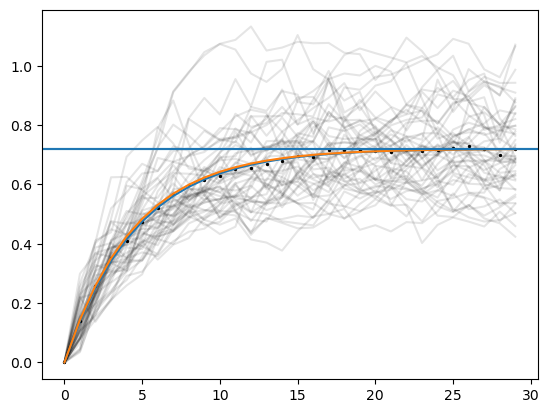

In [1]:
import os
os.chdir('/Users/haozheshan/Dropbox/codes/gp_continual_learning/')
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize, theory, cluster_utils, torch, data, utils, tqdm
from datetime import datetime
import torch.nn.functional as func

%load_ext autoreload
%autoreload 2

n0 = 500  # input dimension
f = 0.2  # feature sparsity
n_data = int(n0 * f)
omega = 0.6  # controls correlation between each new task V and the original V
nseeds = 50
T = 30



def generate_new_v(shared_v, ratio):
    return np.sqrt(1- ratio**2) * shared_v + ratio * torch.normal(torch.zeros(n0))

# initialize readout; it has n_data non-zero dimensions


distance = torch.zeros((nseeds, T))
for seed in range(nseeds):
    task1_inds = np.random.choice(n0, size=n_data, replace=False)
    shared_v = torch.normal(torch.zeros(n0))
    v0 = generate_new_v(shared_v, omega)
    a = v0.clone()
    for i in range(T):
        distance[seed, i] = torch.norm(v0[task1_inds] - a[task1_inds])**2 / torch.norm(v0[task1_inds])**2
        
        new_task_inds = np.random.choice(n0, size=n_data, replace=False)
        new_task_v = generate_new_v(shared_v, omega)
        a[new_task_inds] = new_task_v[new_task_inds]


plt.figure()
# _ = plt.plot(distance.T, color='gray', alpha=0.5)
_ = plt.scatter(range(T), distance.mean(0), s=2, color='k')
plt.plot(distance.T, color='k', alpha=0.1)
offset, tau = utils.exp_fit_and_plot(np.arange(T), distance.mean(0), [1, 0.4])
plt.plot(2 * omega**2 * (1 - (1-f)**np.arange(T)))
plt.axhline(offset)
plt.axhline(2 * omega**2)

# Toy forgetting model 2

## Compute spectrum of real datasets

0.9765624293056647


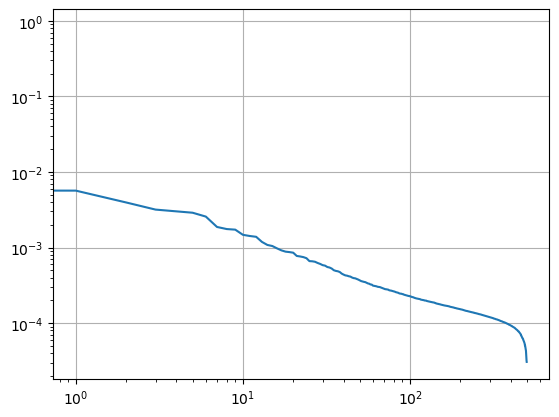

In [224]:
seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
        data.prepare_permuted_dataset(2, 500, 1, dataset_name='mnist',
                                      resample=0,
                                      permutation=1.0, data_path=None, precision=64)
K = theory.arccos_kernel_deep(seq_of_train_x[0], seq_of_train_x[0], depth=9)
_, s, _ = np.linalg.svd(K)
print(np.trace(K))
plt.figure()
plt.loglog(np.arange(0, 500), s)
plt.grid()

In [220]:
x = np.random.normal(np.zeros((n0, 1))) / np.sqrt(n0)
y = np.sqrt(0.1) * x + np.sqrt(0.5) * np.random.normal(np.zeros((n0, 1))) / np.sqrt(n0)
print(np.dot(x.T, y))

nd = 20

avg = 0
nseeds = 1000
for i in range(nseeds):
    basis_t = np.random.normal(np.zeros((nd, n0))) / np.sqrt(n0)
    avg += (x.T @ basis_t.T @ basis_t @ y)**2 / nseeds

print(avg)
print('theory', nd**2/n0**2 * np.dot(x.T, y)**2 + nd / n0**2 * np.linalg.norm(x)**2 * np.linalg.norm(y)**2)

[[0.35507281]]
[[0.00026829]]
theory [[0.00025925]]


In [217]:
nd / n0**2 * np.linalg.norm(x)**2 * np.linalg.norm(y)**2

0.00012560987676480935

In [ ]:
n0 = 500
nd = 50
T = 50
nseeds = 50
a = np.zeros((n0, 1))

all_a0_outputs = np.zeros((nseeds, T))
all_a0_errors = np.zeros((nseeds, T))
all_a0_aligns = np.zeros((nseeds, T))
term1 = np.zeros((nseeds, T))
term2 = np.zeros((nseeds, T))
term3 = np.zeros((nseeds, T))

# all_basis = np.random.normal((np.zeros((n0, n0)))) / np.sqrt(n0)
# all_basis, _, _ = np.linalg.svd(all_basis)
# all_basis = np.eye(n0)

for seed in range(nseeds):

    P0 = None
    V0 = None
    Sigma0 = None

    for i in range(T):
        basis_t = np.random.normal(np.zeros((nd, n0))) / np.sqrt(n0)
        _, _, basis_t = np.linalg.svd(basis_t)
        basis_t = basis_t[:nd]

        # basis_t = all_basis[np.random.choice(n0, nd, replace=True)]
        # basis_t = basis_t / np.linalg.norm(basis_t, axis=1, keepdims=True)
        P_t = basis_t.T @ basis_t
        spectrum = np.arange(1, nd+1)**-1.0
        Sigma_t = basis_t.T @ np.diag(spectrum) @ basis_t

        V_t = basis_t.T @ (spectrum.reshape(-1, 1)**1/2 * np.sign(np.random.normal(np.zeros((nd, 1)))))
        # V_t = basis_t.T @ np.arange(1, nd+1)**-1.0
        V_t /= np.sqrt(np.abs(V_t.T @ Sigma_t @ V_t))
        

        if i == 0:
            P0 = P_t
            V0 = V_t
            Sigma0 = Sigma_t
        
        if i > 0:
            term1[seed, i] = V_t.T @ Sigma0 @ V_t
            term2[seed, i] = V_t.T @ Sigma0 @ (a - P_t @ a)
            term3[seed, i] = (all_a0_outputs[seed, i - 1] - (a - P_t @ a).T @ Sigma0 @ (a - P_t @ a)) / all_a0_outputs[seed, i - 1]

        a = a - P_t @ a + V_t
        
        all_a0_outputs[seed, i] = float(a.T @ Sigma0 @ a)
        all_a0_errors[seed, i ] = float((a.T - V0.T) @ Sigma0 @ (a-V0) / (V0.T @ Sigma0 @ V0))
        all_a0_aligns[seed, i] = float(a.T @ Sigma0 @ V0)


Text(0.5, 1.0, 'predicted 9.491')

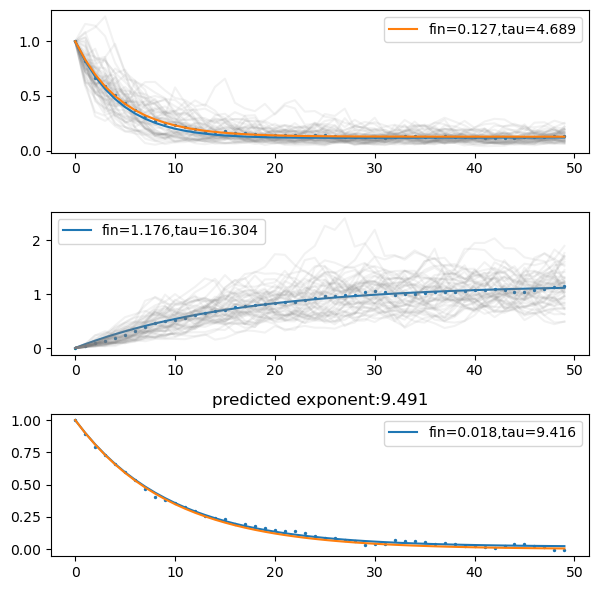

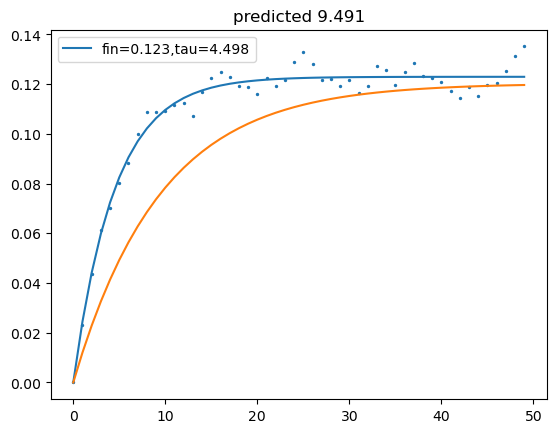

In [ ]:
M1 = all_a0_outputs.mean(0)
L1 = all_a0_errors.mean(0)
A1 = -0.5 * (L1 - M1 - 1)
beta_sq_experiment = M1 - A1**2

gamma_alpha = 1 - nd/n0
gamma_beta_sq = (1 - nd/n0)
tau_alpha = - 1 / np.log(gamma_alpha)
tau_beta_sq = -1 / np.log(gamma_beta_sq)
beta_sq_asymptote = term1.mean() / (1 - gamma_beta_sq)
alpha = np.exp(-np.arange(T) / tau_alpha)
beta_sq = beta_sq_asymptote * (1 - np.exp(-np.arange(T) / tau_beta_sq))

predicted_Mt = alpha**2 + beta_sq



fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(6, 6))
plt.sca(axes[0])
plt.plot(all_a0_outputs.T, color='gray', alpha=0.1)
plt.plot(predicted_Mt)
fin_m, tau_m = utils.plot_and_fit(M1)
# plt.plot(range(T), 1 + (asymptotic_m - 1) * (1 - np.exp(-np.arange(T) / tau_m)))
# plt.plot(np.arange(T), np.exp)
plt.legend()
# plt.title(f'predicted exponent:{tau_m_theory:.3f}')

plt.sca(axes[1])
_, tau = utils.plot_and_fit(L1)
plt.plot(all_a0_errors.T, color='gray', alpha=0.1)

plt.legend()

plt.sca(axes[2])
_, tau = utils.plot_and_fit(A1)
plt.plot(alpha)
plt.title(f'predicted exponent:{tau_alpha:.3f}')
plt.legend()
plt.tight_layout()


plt.figure()
utils.plot_and_fit(beta_sq_experiment)
plt.plot(beta_sq)
plt.legend()
plt.title(f'predicted {tau_beta_sq:.3f}')


/var/folders/2m/x49c8w2s4k38812zxyl8cc540000gn/T/ipykernel_93975/1059619211.py:1: RuntimeWarning: divide by zero encountered in divide
  beta_diff = (np.diff(beta_sq_experiment) - term1.mean(0)[1:]) / beta_sq_experiment[:T-1]


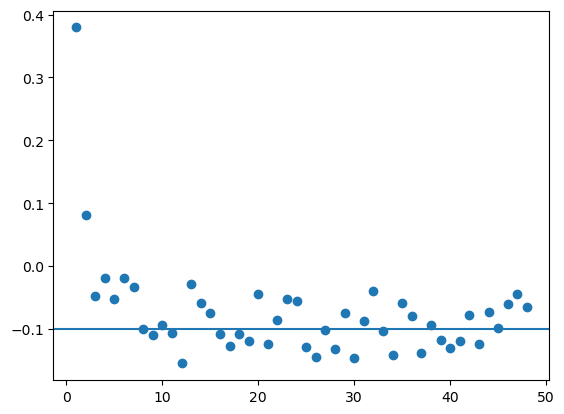

In [ ]:
beta_diff = (np.diff(beta_sq_experiment) - term1.mean(0)[1:]) / beta_sq_experiment[:T-1]

plt.figure()
plt.scatter(range(T-1), beta_diff)
plt.axhline(gamma_beta_sq - 1)

# Toy forgetting model 3

In [ ]:
n0 = 1000
nd = 100
T = 50
nseeds = 50


all_a0_outputs = np.zeros((nseeds, T))
all_a0_errors = np.zeros((nseeds, T))


for seed in range(nseeds):

    basis_0 = None
    V_0 = None
    Sigma0 = None
    spectrum = np.arange(1, nd+1)**-0.5

    a = np.zeros((n0))

    for i in range(T):
        basis_t = np.random.choice(n0, nd, replace=False)
        
        V_t = np.sqrt(spectrum) / np.sqrt(np.sum(spectrum**2)) * np.sign(np.random.normal(np.zeros(nd)))

        if i == 0:
            basis_0 = basis_t
            V_0 = V_t

        a[basis_t] = V_t
        all_a0_outputs[seed, i] = np.sum(a[basis_0]**2 * spectrum)
        all_a0_errors[seed, i ] = np.sum((a[basis_0]-V_0)**2 * spectrum)


Text(0.5, 1.0, '9.081088971382124')

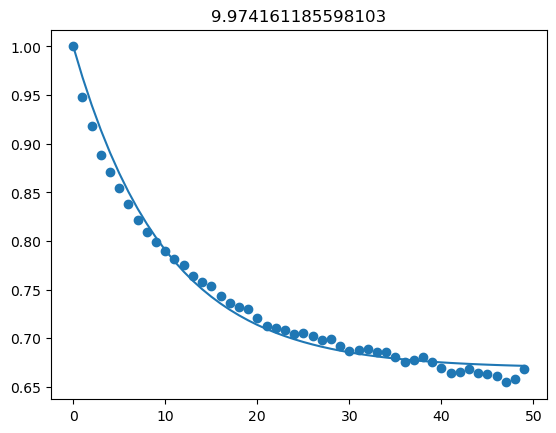

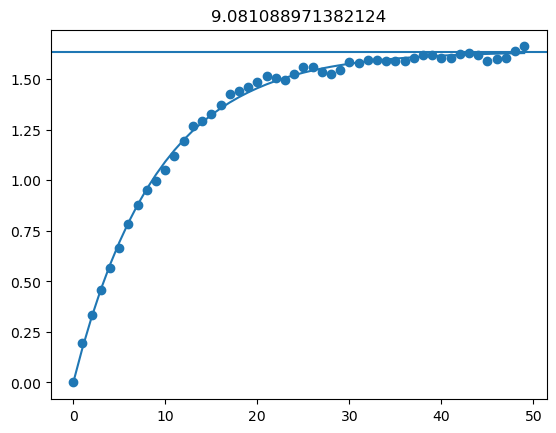

In [ ]:
plt.figure()
plt.scatter(range(T), all_a0_outputs.mean(0))
_, tau = utils.exp_fit_and_plot(np.arange(T), all_a0_outputs.mean(0), p0=[1, 1])
plt.title(f'{tau}')

plt.figure()
plt.scatter(range(T), all_a0_errors.mean(0))
asympt, tau = utils.exp_fit_and_plot(np.arange(T), all_a0_errors.mean(0), p0=[1, 1])
plt.axhline(asympt)
plt.title(f'{tau}')

Text(0.5, 1.0, '(10.015621581930326, 2.157763054207538)')

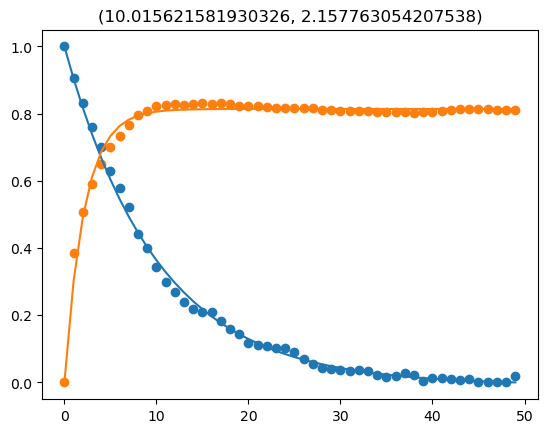

In [ ]:
M1 = all_a0_outputs.mean(0)
L1 = all_a0_errors.mean(0)
alpha_process = (-1/2 * (L1 - M1 - 1))**2
beta_process = M1 - alpha_process
beta_process[beta_process < 0] = 0

plt.figure()
plt.scatter(range(T), alpha_process**0.5)
_, tau_alpha = utils.exp_fit_and_plot(np.arange(T), alpha_process**0.5, p0=[1, 1])
_, tau_beta = utils.exp_fit_and_plot(np.arange(T), beta_process**0.5, p0=[1, 1])
plt.scatter(range(T), beta_process**0.5)
plt.title(f'{tau_alpha, tau_beta}')

In [5]:
tr_y

tensor([[-0.3712, -0.3448, -1.0839,  ..., -0.1336, -0.0544, -1.0839],
        [ 0.1777,  0.2408,  0.2093,  ...,  1.3621,  1.2674,  0.7620],
        [ 0.9689,  1.0457,  1.0841,  ..., -1.0791, -1.5782, -1.5910],
        ...,
        [ 1.3003,  1.3003,  1.3003,  ..., -0.5262, -0.5262, -0.5262],
        [-0.7811, -0.7542, -0.8887,  ...,  0.6716,  0.7792,  0.2412],
        [ 2.1778,  2.8734,  2.0266,  ..., -1.4513, -0.1206, -0.8162]])

In [9]:
import data, torch
tr_x, te_x, tr_y, te_y = data.load_dataset('cifar100', 99999, 99999)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
te_x.shape

torch.Size([10000, 3072])